<a id='top'></a>
# calwebb_detector1 run stage
---
**Author**: Jonathan Aguilar (jaguilar@stsci.edu) | **Latest Update**: 8 Nov 2023

* [Introduction](#intro)
* [Non-pipeline imports](#imports)
* [Convenience tools](#convenience_tools)
* [Collect uncal files](#file_selection)
* [Run Stage 1](#detector1)

<a id='intro'></a>
## Introduction

This notebook run the Stage 1 pipeline on all the relevant reference science, PSF and background files for the JWST-ERS-1386 observations of HIP 65426 with the F1550C coronagraph. The relevant observation numbers are:

- Science observations: 8, 9
- Science backgrounds: 30
- Reference observations: 7
- Reference backgrounds: 31

For more details, especially on how to customize the individual pipeline steps, see `calwebb-detector1-single_exposure.ipynb` as well as the online pipeline documentation and examples:
- https://jwst-pipeline.readthedocs.io/en/latest/jwst/pipeline/calwebb_detector1.html#calwebb-detector1
- https://github.com/spacetelescope/jwebbinar_prep/blob/main/pipeline_inflight/imaging_mode_stage_1.ipynb

Here we will simply be using default parameters, except that the output directory will be set to `./stage1/output/`

<a id='imports'></a>
## Imports

In [1]:
import os
from collections import OrderedDict
from pathlib import Path

In [2]:
import numpy as np

In [3]:
import matplotlib as mpl
from matplotlib import pyplot as plt
from astropy.io import fits

<a id='convenience_tools'></a>
## Convenience tools

Environment paths and functions that make life easier.

First, set up a local CRDS directory. When the pipeline pulls a reference file from CRDS for the first time, it will write a copy to this directory. All subsequent reads of the reference file will redirect to the local directory instead of sending the file again over the network.

See https://jwst-pipeline.readthedocs.io/en/latest/jwst/user_documentation/reference_files_crds.html#crds

In [4]:
os.environ['CRDS_PATH'] = '/Volumes/agdisk/crds/'
# os.environ['CRDS_PATH'] = ''
os.environ['CRDS_SERVER_URL'] = 'https://jwst-crds.stsci.edu'

Advanced users - uncomment the cell below and specify the context if you have a specific combination of reference files you want to use

In [5]:
# os.environ['CRDS_CONTEXT'] = 'jwst_1140.pmap'

In [6]:
# some plot formatting
mpl.rcParams['image.origin'] = "lower"

In [7]:
# you may need to run this command twice for plots to pop up correctly
# %matplotlib auto
%matplotlib inline

In [8]:
# this helper function to map out a particular DQ flag will be useful
# DQ flags can be found here: 
# https://jwst.readthedocs.io/en/latest/jwst/references_general/references_general.html#data-quality-flags
def get_dq_flag(flag, dq_img):
    """return the pixels that have a given DQ flag"""
    bad_bitvalue = dqflags.pixel[flag]
    flags = np.bitwise_and(dq_img, bad_bitvalue).astype(bool)
    return flags

### Logging configuration

The logging statements can be quite extensive, which can make a notebook cumbersome to read on Github in an executed state. To help the users, we're going to redirect the logging statements to log files stored in each step's output folder. That way you the notebook will be stripped down to the commands and diagnostic output, but the logging statements are preserved so users can compare them against the output in their own notebooks. 

In the cell below you'll find the template to the logging configuration file. The logging configuration file contains the path to the log file and the level of verbosity. At each step, we will call the `generate_log_file` function to create a config file, and pass that file to the step. The step will then generate a log file in the output directory.

In [9]:
cfg_template = """
[*]
handler = file:path_to_file
level = INFO
"""
def generate_log_file(output_dir, extra_text=''):
    """
    Place a logging configuration file in the output director.
    Add extra text before the extension if you want.
    """
    cfgfile_name = "detector1"+extra_text+".cfg"
    logfile_name = "detector1"+extra_text+".log"
    cfg = cfg_template.replace("path_to_file", str(output_dir / logfile_name))
    cfgfile_path = output_dir / cfgfile_name
    with open(str(cfgfile_path), 'w') as f:
        f.write(cfg)
    return str(cfgfile_path) if cfgfile_path.exists() else None

<a id="file_selection"></a>
## Collect uncal files

The cell below will access MAST to retrieve the relevant exposures from Observations 4, 5, 6, 28, and 29 of the High-contrast ERS program, PID 1386. 

If you would like to use different exposures, please replace the `filenames` variable with a list of paths to those files.

In [10]:
filenames = [
    'jw01386008001_04101_00001_mirimage_uncal.fits',  # Science target, roll 1
    'jw01386009001_04101_00001_mirimage_uncal.fits',  # Science target, roll 2
    'jw01386007001_04101_00001_mirimage_uncal.fits',  # PSF reference star observations
    'jw01386007001_04101_00002_mirimage_uncal.fits',
    'jw01386007001_04101_00003_mirimage_uncal.fits',
    'jw01386007001_04101_00004_mirimage_uncal.fits',
    'jw01386007001_04101_00005_mirimage_uncal.fits',
    'jw01386007001_04101_00006_mirimage_uncal.fits',
    'jw01386007001_04101_00007_mirimage_uncal.fits',
    'jw01386007001_04101_00008_mirimage_uncal.fits',
    'jw01386007001_04101_00009_mirimage_uncal.fits',
    'jw01386030001_02101_00001_mirimage_uncal.fits',  # Science backgrounds
    'jw01386030001_03101_00001_mirimage_uncal.fits',
    'jw01386031001_02101_00001_mirimage_uncal.fits',  # PSF reference star backgrounds
    'jw01386031001_03101_00001_mirimage_uncal.fits',
]
from astroquery.mast import Observations
for filename in filenames:
    Observations.download_file(f"mast:JWST/product/{filename}", local_path= f"./uncal/{filename}")

INFO: Found cached file ./uncal/jw01386008001_04101_00001_mirimage_uncal.fits with expected size 2419286400. [astroquery.query]
INFO: Found cached file ./uncal/jw01386009001_04101_00001_mirimage_uncal.fits with expected size 2419286400. [astroquery.query]
INFO: Found cached file ./uncal/jw01386007001_04101_00001_mirimage_uncal.fits with expected size 306489600. [astroquery.query]
INFO: Found cached file ./uncal/jw01386007001_04101_00002_mirimage_uncal.fits with expected size 306489600. [astroquery.query]
INFO: Found cached file ./uncal/jw01386007001_04101_00003_mirimage_uncal.fits with expected size 306489600. [astroquery.query]
INFO: Found cached file ./uncal/jw01386007001_04101_00004_mirimage_uncal.fits with expected size 306489600. [astroquery.query]
INFO: Found cached file ./uncal/jw01386007001_04101_00005_mirimage_uncal.fits with expected size 306489600. [astroquery.query]
INFO: Found cached file ./uncal/jw01386007001_04101_00006_mirimage_uncal.fits with expected size 306489600. [

Let's do a quick inspection of one of the files

In [11]:
# print some basic information
uncal_file = f"./uncal/{filenames[0]}"
fits.info(uncal_file)

Filename: ./uncal/jw01386008001_04101_00001_mirimage_uncal.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     182   ()      
  1  SCI           1 ImageHDU        80   (288, 224, 250, 60)   int16 (rescales to uint16)   
  2  REFOUT        1 ImageHDU        13   (288, 56, 250, 60)   int16 (rescales to uint16)   
  3  GROUP         1 BinTableHDU     38   300R x 13C   [I, I, I, J, I, 26A, I, I, I, I, 36A, D, D]   
  4  INT_TIMES     1 BinTableHDU     24   60R x 7C   [J, D, D, D, D, D, D]   
  5  ASDF          1 BinTableHDU     11   1R x 1C   [8059B]   


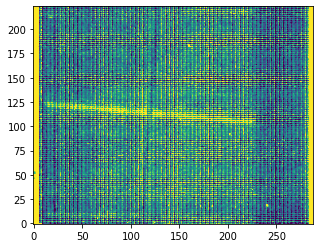

In [12]:
# a simple plot
fig, ax = plt.subplots(1, 1)
img = np.nanmean(fits.getdata(uncal_file, 1), axis=(0, 1))
imlims = dict(zip(['vmin', 'vmax'], np.nanquantile(img, [0.1, 0.9])))
ax.imshow(img, **imlims, origin='lower')

<a id='detector1'></a>

## Run calwebb_detector1 on each file

The command `Detector1Pipeline().get_pars()` will return a dictionary listing all the available parameters and their default values.

This dictionary can be modified and then used with the commend `Detector1Pipeline.call(filename, **parameter_dict)`.

In [13]:
import jwst
jwst.__version__

'1.11.3'

In [14]:
from jwst.pipeline import Detector1Pipeline

In [15]:
for i, f in enumerate(filenames):
    # run det1
    print("\n\n\n", i+1, len(filenames), "\n\n\n")
    filename = str(Path("uncal") / f)
    output_dir = Path("stage1/output/")
    res1 = Detector1Pipeline.call(
        filename,
        output_dir=str(output_dir),
        save_results=True,
        logcfg=generate_log_file(output_dir, "-"+Path(filename).stem),
        steps={
            'jump': {'maximum_cores': 'half'},
            'ramp_fit': {'maximum_cores': 'half'}
        }
    )




 1 15 





2023-11-16 11:40:27,905 - stpipe - INFO - PARS-JUMPSTEP parameters found: /Volumes/agdisk/crds/references/jwst/miri/jwst_miri_pars-jumpstep_0002.asdf
2023-11-16 11:40:27,928 - CRDS - ERROR -  Error determining best reference for 'pars-undersamplingcorrectionstep'  =   Unknown reference type 'pars-undersamplingcorrectionstep'
2023-11-16 11:40:27,931 - stpipe - INFO - PARS-DETECTOR1PIPELINE parameters found: /Volumes/agdisk/crds/references/jwst/miri/jwst_miri_pars-detector1pipeline_0001.asdf





 2 15 





2023-11-16 12:23:33,277 - CRDS - ERROR -  Error determining best reference for 'pars-undersamplingcorrectionstep'  =   Unknown reference type 'pars-undersamplingcorrectionstep'





 3 15 





2023-11-16 13:00:37,162 - CRDS - ERROR -  Error determining best reference for 'pars-undersamplingcorrectionstep'  =   Unknown reference type 'pars-undersamplingcorrectionstep'





 4 15 





2023-11-16 13:02:36,842 - CRDS - ERROR -  Error determining best reference for 'pars-undersamplingcorrectionstep'  =   Unknown reference type 'pars-undersamplingcorrectionstep'





 5 15 





2023-11-16 13:04:59,203 - CRDS - ERROR -  Error determining best reference for 'pars-undersamplingcorrectionstep'  =   Unknown reference type 'pars-undersamplingcorrectionstep'





 6 15 





2023-11-16 13:07:23,450 - CRDS - ERROR -  Error determining best reference for 'pars-undersamplingcorrectionstep'  =   Unknown reference type 'pars-undersamplingcorrectionstep'





 7 15 





2023-11-16 13:09:41,441 - CRDS - ERROR -  Error determining best reference for 'pars-undersamplingcorrectionstep'  =   Unknown reference type 'pars-undersamplingcorrectionstep'





 8 15 





2023-11-16 13:12:11,463 - CRDS - ERROR -  Error determining best reference for 'pars-undersamplingcorrectionstep'  =   Unknown reference type 'pars-undersamplingcorrectionstep'





 9 15 





2023-11-16 13:14:33,071 - CRDS - ERROR -  Error determining best reference for 'pars-undersamplingcorrectionstep'  =   Unknown reference type 'pars-undersamplingcorrectionstep'





 10 15 





2023-11-16 13:16:54,844 - CRDS - ERROR -  Error determining best reference for 'pars-undersamplingcorrectionstep'  =   Unknown reference type 'pars-undersamplingcorrectionstep'





 11 15 





2023-11-16 13:18:43,137 - CRDS - ERROR -  Error determining best reference for 'pars-undersamplingcorrectionstep'  =   Unknown reference type 'pars-undersamplingcorrectionstep'





 12 15 





2023-11-16 13:20:39,680 - CRDS - ERROR -  Error determining best reference for 'pars-undersamplingcorrectionstep'  =   Unknown reference type 'pars-undersamplingcorrectionstep'





 13 15 





2023-11-16 13:58:29,602 - CRDS - ERROR -  Error determining best reference for 'pars-undersamplingcorrectionstep'  =   Unknown reference type 'pars-undersamplingcorrectionstep'





 14 15 





2023-11-16 14:37:30,067 - CRDS - ERROR -  Error determining best reference for 'pars-undersamplingcorrectionstep'  =   Unknown reference type 'pars-undersamplingcorrectionstep'





 15 15 





2023-11-16 14:39:43,034 - CRDS - ERROR -  Error determining best reference for 'pars-undersamplingcorrectionstep'  =   Unknown reference type 'pars-undersamplingcorrectionstep'


The results are stored in `./stage1/output/`.